# Cats VS Dogs Notebook
In this notebook we will try classifing pictures of dogs/cats from the dataset Dogs vs. Cats (https://www.kaggle.com/c/dogs-vs-cats).  
Using neural-networks is forbidden.

In [48]:
#libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

## Data Preview

In [2]:
#example picture
exm=cv2.imread("Datasets/DvC/cat.0.jpg")#loading image
exm = cv2.cvtColor(exm, cv2.COLOR_BGR2RGB)#converting from BGR to RGB

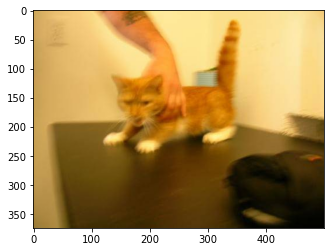

In [3]:
plt.imshow(exm)

In [4]:
exm.shape

(374, 500, 3)

We want to work with same-size images, we will reshape all images to the same scale.

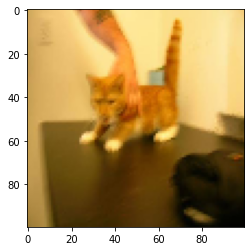

In [5]:
#first option- 100*100 colored
col_exm=cv2.resize(exm,(100,100))
plt.imshow(col_exm)

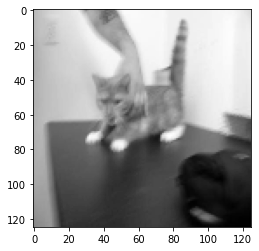

In [6]:
#second option- 125*125 grayscale
bnw_exm=cv2.cvtColor(exm, cv2.COLOR_RGB2GRAY)#grayscale image
bnw_exm=cv2.resize(bnw_exm,(125,125))
plt.imshow(bnw_exm,cmap='gray')

In [7]:
bnw_exm.shape

(125, 125)

The RGB dimentions were replaced with a single gray dimention

In [8]:
bnw_exm

array([[167, 173, 174, ..., 210, 206, 204],
       [167, 173, 174, ..., 211, 207, 205],
       [167, 173, 174, ..., 212, 208, 206],
       ...,
       [126, 128, 129, ...,   3,   3,   2],
       [125, 127, 129, ...,   3,   3,   3],
       [123, 124, 128, ...,   2,   2,   2]], dtype=uint8)

We can see that in both cases, even thogh the image is originally blurred we can still recognize the cat.  
Let's hope the computer will be able too.

We will work both on colored and grayscaled data and decide at the end what performs better and use this method for scoring.

# Option 1: Colored 100*100

## Data Importing

In [9]:
#Loading data
from os import listdir
X = list()
for file in listdir('Datasets/DvC/'):
    # load image
    im = cv2.imread("Datasets/DvC/"+file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#to RGB
    #add to X
    X.append(cv2.resize(im,(100,100)))
    

The first 12500 images are cats and the last 12500 are dogs.  

In [10]:
#create labels
labels=np.zeros(12500)
y=np.concatenate((labels,np.ones(12500)))
y

array([0., 0., 0., ..., 1., 1., 1.])

In [11]:
y.shape

(25000,)

Text(0.5, 1.0, 'label is 0.0')

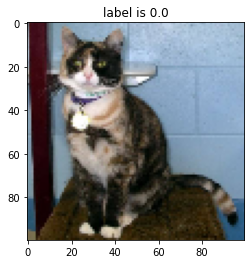

In [12]:
plt.imshow(X[12499])
plt.title('label is '+str(y[12499]))

Text(0.5, 1.0, 'label is 1.0')

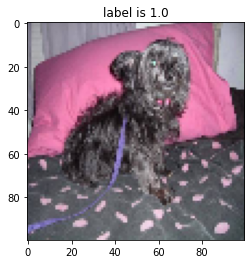

In [13]:
plt.imshow(X[12500])
plt.title('label is '+str(y[12500]))

## Data Preparations

In [14]:
#reducing to 2 dim array (for the algorithms)
X=np.asarray(X)
X.shape

(25000, 100, 100, 3)

In [15]:
X=X.reshape((25000,10000,3))
X=X.reshape((25000,30000))
X.shape

(25000, 30000)

In [16]:
#single picture as vector
X[15]

array([ 53,  49,   7, ...,  29, 156, 101], dtype=uint8)

In [17]:
#scaling
X.max()

255

In [18]:
X=X/255

In [19]:
#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=42)
X_train.shape

(20000, 30000)

We won't touch the test sets until the very end.

We will extract validation sets from the training sets to help us choose the best estimator.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=4000, random_state=42)
y_val.shape

(4000,)

The data is scaled and divided.  
The data is balanced, therefore the 'accuracy' metric will serve us well.

## Dimensionality reduction

Our data have too many dimentions (30000!), we have to reduce this number for our algorithms to run in a reasonable timeframe.  
We will use PCA (Principal Component Analysis) to reduce the dimention of our problem.  
We will create 2 reduced datasets (for each color scheme), one with 150 dimentions and the other with 20.  

In [21]:
from sklearn.decomposition import PCA
#20 dimentions
pca20=PCA(n_components=20,random_state=7)
X_train_20=pca20.fit_transform(X_train)

In [22]:
X_train_20.shape

(16000, 20)

In [23]:
#transform col_val by the same algorithm
X_val_20=pca20.transform(X_val)

In [24]:
#150 dimentions
pca150=PCA(n_components=150,random_state=7)
X_train_150=pca150.fit_transform(X_train)
X_val_150=pca150.transform(X_val)

In [25]:
X_train_150.shape

(16000, 150)

## Decision tree
### 20 dimentions

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score#to get close-to-life score
dtc=DecisionTreeClassifier(random_state=0,max_depth=15)
cvs=cross_val_score(dtc,X_train_20,y_train,cv=5,scoring='accuracy')
cvs

array([0.551875 , 0.564375 , 0.5565625, 0.55     , 0.558125 ])

In [43]:
cvs.mean()

0.5561875

The scores are really bad, just slightly above dummy model (coin flip/ persistent).  
Let's search for better depths that will still run in reasonable timeframe.

In [47]:
from sklearn.model_selection import GridSearchCV
grid=GridSearchCV(dtc,{'max_depth':[15,20,25,30,35]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=0),
             param_grid={'max_depth': [15, 20, 25, 30, 35]},
             scoring='accuracy')

In [49]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.323304,0.013651,0.000953,0.000043,15,{'max_depth': 15},0.551875,0.564375,0.556562,0.550000,0.558125,0.556187,0.005056,1
1,0.362528,0.008848,0.001201,0.000396,20,{'max_depth': 20},0.540625,0.552188,0.549687,0.531563,0.557813,0.546375,0.009253,2
2,0.357780,0.014018,0.000999,0.000001,25,{'max_depth': 25},0.540937,0.544687,0.556875,0.532188,0.545000,0.543937,0.007952,3
3,0.371739,0.011550,0.001796,0.000398,30,{'max_depth': 30},0.550000,0.537813,0.548438,0.530312,0.545625,0.542437,0.007372,4
4,0.356539,0.011047,0.001399,0.000493,35,{'max_depth': 35},0.544687,0.536563,0.553750,0.525937,0.545625,0.541313,0.009419,5


The results are very interesting.

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

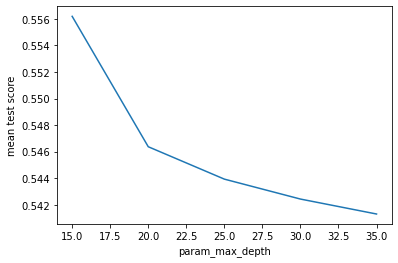

In [50]:
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

The accuracy decreases the deeper the tree.

In [51]:
#search with shalower trees
grid=GridSearchCV(dtc,{'max_depth':[5,7,10,12,15]},cv=5,scoring='accuracy')
grid.fit(X_train_20,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=15, random_state=0),
             param_grid={'max_depth': [5, 7, 10, 12, 15]}, scoring='accuracy')

<AxesSubplot:xlabel='param_max_depth', ylabel='mean test score'>

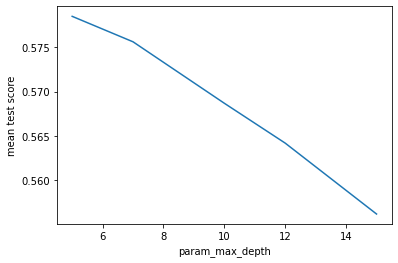

In [52]:
cv_res=pd.DataFrame(grid.cv_results_)
cv_res.plot(y='mean_test_score',x='param_max_depth',legend=False,ylabel='mean test score')

The results are still low, but the tree can serve as a weak learner for the following algorithms.

In [ ]:
#full depth try
dtc.max_depth=none
cvs=cross_val_score(dtc,X_train_20,y_train,cv=5,scoring='accuracy')

In [28]:
##choose best at the end
#X_test_20=pca20.transform(X_test)
#X_test_150=pca150.transform(X_test)

# Option 2: Black and white 125*125
We redo all the steps from before, explanation will be minimal.

In [29]:
#del X #reset variable
#X = list()
#for file in listdir('Datasets/DvC/'):
#    # load image
#    im = cv2.imread("Datasets/DvC/"+file)
#    #add to X as black and whita image
#    bnw_im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)#grayscale image
#    X.append(cv2.resize(bnw_im,(125,125)))

In [30]:
##reducing to 2 dim array (for the algorithms)
#X=np.asarray(X)
#X.shape

In [31]:
#X=X.reshape((25000,125*125))
#X.shape

In [32]:
##train-test split (same split as before)
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, random_state=42)
#X_train.shape

In [33]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=4000, random_state=42)
#y_val.shape

Data is ready to work.

## Dimensionality reduction
See Option 1:Colored for explanation

In [34]:
#from sklearn.decomposition import PCA
##20 dimentions
#pca20=PCA(n_components=20,random_state=7)
#X_train_20=pca20.fit_transform(X_train)

In [35]:
#X_train_20.shape

In [36]:
##transform col_val by the same algorithm
#X_val_20=pca20.transform(X_val)

In [37]:
##150 dimentions
#pca150=PCA(n_components=150,random_state=7)
#X_train_150=pca150.fit_transform(X_train)
#X_val_150=pca150.transform(X_val)

In [38]:
#X_train_150.shape